## ARIMA Forecasting (Tuition Gap Modeling)

This analysis applies an ARIMA model to forecast the University of Virginia’s tuition gap between out-of-state and in-state students. ARIMA (AutoRegressive Integrated Moving Average) is designed to handle non-stationary time series data by differencing and modeling temporal dependencies.

## Pipeline Steps
1. Data Preparation
- Loaded Combined_UVA_Tuition_Cleaned.csv, containing yearly tuition gap values from 1970–2024.
- Split data into:
- Train: 1970–2013
- Test: 2014–2023
- Defined the modeling target as Tuition_Gap

2. Model Configuration and Grid Search
- Implemented an ARIMA grid search over parameter ranges:
- p: [0, 1, 2] (autoregressive terms)
- d: [0, 1, 2] (differencing order)
- q: [0, 1, 2] (moving average terms)
- Selected the model with the lowest AIC on training data.
The best configuration was ARIMA(0, 2, 2), confirming the need for second-order differencing due to strong non-stationarity

3. Training and Evaluation
- Fitted ARIMA(0,2,2) on the training set and forecasted the 10-year test period.
- Performance metrics: R² = 0.113 // MAPE = 7.15%
- Directional Accuracy (last 5 years) = 1.00
Indicates the model captures long-term upward direction accurately, though magnitude fit remains modest

4. Full-Series Refit and Forecast Extension
- Refit ARIMA(0,2,2) on the full 1970–2024 dataset.
- Forecasted tuition gap through 2030, showing a continued widening between in-state and out-of-state tuition.
Forecast results exported to:
- arima_future_forecast_2030.csv
- arima_test_predictions.csv
- arima_metrics.csv

5. Visualization
Generated a line plot displaying:
- Training (1970–2013) and test (2014–2023) data
- ARIMA(0,2,2) predicted values
- Future forecasts through 2030

Plot illustrates a smooth, consistent upward trajectory with no cyclical components, consistent with tuition’s long-term inflation-driven behavior

### Outputs
- ../OUTPUT/03_arima_forecast/arima_test_predictions.csv
- ../OUTPUT/03_arima_forecast/arima_future_forecast_2030.csv
- ../OUTPUT/03_arima_forecast/arima_metrics.csv
- ../OUTPUT/03_arima_forecast/arima_gap_forecast.png

The ARIMA(0,2,2) model effectively models UVA’s tuition gap as a trend-dominated, non-stationary series, providing a strong statistical baseline for comparison with more flexible approaches such as Holt’s Linear Trend and the Unobserved Components Model.

In [10]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [11]:
DATA_PATH = "../DATA/Combined_UVA_Tuition_Cleaned.csv"  
OUT_DIR = "../OUTPUT/04_arima_forecast/"
COL_YEAR = "Year_Start"
COL_GAP  = "Tuition_Gap"

TEST_YEARS = 10  
FORECAST_END_YEAR = 2030 

P = [0, 1, 2]    
D = [0, 1, 2]     
Q = [0, 1, 2]    

os.makedirs(OUT_DIR, exist_ok=True)

In [12]:
def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.where(y_true == 0, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def r2(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan

def grid_search_arima(y, p_list=P, d_list=D, q_list=Q):
    """Return (best_order, best_model_fit) minimizing AIC on training series y."""
    best_aic = np.inf
    best_order = None
    best_model = None
    for p, d, q in itertools.product(p_list, d_list, q_list):
        try:
            model = SARIMAX(
                y, order=(p, d, q),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, d, q)
                best_model = model
        except Exception:
            continue
    if best_model is None:
        raise RuntimeError("ARIMA grid search failed. Try widening p,d,q ranges.")
    return best_order, best_model


In [13]:
df = pd.read_csv(DATA_PATH)

missing = [c for c in [COL_YEAR, COL_GAP] if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce").astype("Int64")
df[COL_GAP]  = pd.to_numeric(df[COL_GAP], errors="coerce")

df = df.dropna(subset=[COL_YEAR, COL_GAP]).sort_values(COL_YEAR).reset_index(drop=True)

years = df[COL_YEAR].to_numpy()
y_all = df[COL_GAP].to_numpy(dtype=float)

In [14]:
split_idx = max(0, len(df) - TEST_YEARS)
train_years = years[:split_idx]
test_years  = years[split_idx:]
y_train     = y_all[:split_idx]
y_test      = y_all[split_idx:]

print(f"Train years: {train_years[0]}–{train_years[-1]} | Test years: {test_years[0]}–{test_years[-1]}")


Train years: 1970–2013 | Test years: 2014–2023


In [15]:
order, arima_train_fit = grid_search_arima(y_train)
print(f"Best ARIMA order by AIC on train: {order}")


Best ARIMA order by AIC on train: (0, 2, 2)


In [16]:
test_forecast = arima_train_fit.get_forecast(steps=len(y_test)).predicted_mean

arima_mape = mape(y_test, test_forecast)
arima_r2   = r2(y_test, test_forecast)

last_n = min(5, len(y_test))
if last_n > 0:
    dir_true = np.sign(np.diff(y_test[-(last_n+1):]))
    dir_pred = np.sign(np.diff(test_forecast[-(last_n+1):]))
    arima_dir = float((dir_true == dir_pred).mean())
else:
    arima_dir = np.nan

print(f"ARIMA{order} → Test R²={arima_r2:.3f}, MAPE={arima_mape:.2f}%, Direction(last5)={arima_dir:.2f}")

# Save test preds
pd.DataFrame({
    "year": test_years,
    "gap_actual": y_test,
    "gap_pred_arima": test_forecast
}).to_csv(f"{OUT_DIR}/arima_test_predictions.csv", index=False)


ARIMA(0, 2, 2) → Test R²=0.113, MAPE=7.15%, Direction(last5)=1.00


In [17]:
last_year = int(years[-1])
extra_steps = int(FORECAST_END_YEAR - last_year)

future_years = np.array([], dtype=int)
future_forecast = np.array([], dtype=float)

if extra_steps > 0:
    full_fit = SARIMAX(
        y_all, order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    future_forecast = full_fit.get_forecast(steps=extra_steps).predicted_mean
    future_years = np.arange(last_year + 1, FORECAST_END_YEAR + 1, dtype=int)

    pd.DataFrame({
        "year": future_years,
        "gap_forecast_arima": future_forecast
    }).to_csv(f"{OUT_DIR}/arima_future_forecast_2030.csv", index=False)

In [18]:
pd.DataFrame([{
    "best_order": str(order),
    "test_R2": arima_r2,
    "test_MAPE": arima_mape,
    "directional_accuracy_last5": arima_dir
}]).to_csv(f"{OUT_DIR}/arima_metrics.csv", index=False)

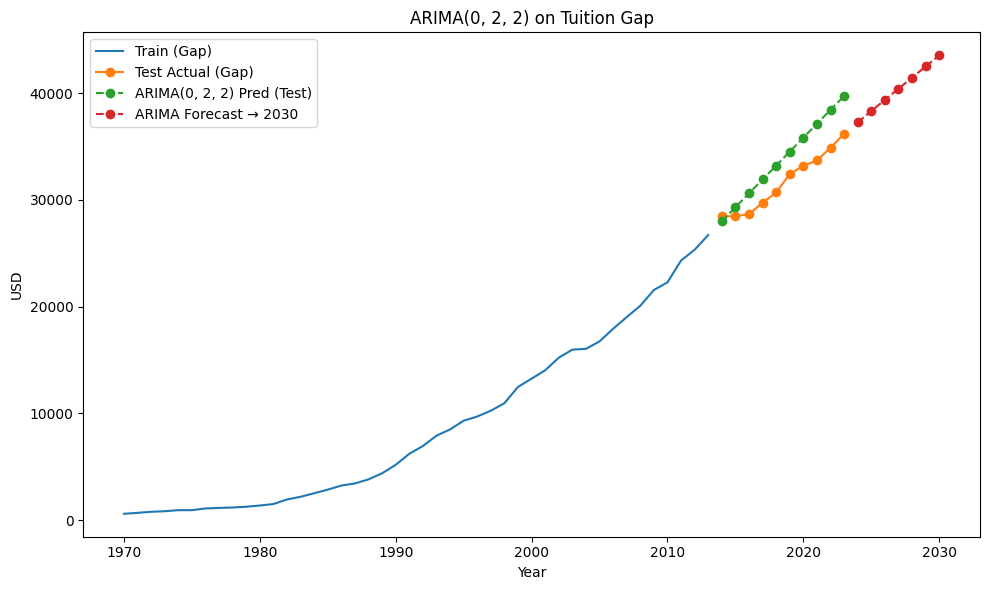

Saved: ../OUTPUT/04_arima_forecast//arima_test_predictions.csv, ../OUTPUT/04_arima_forecast//arima_future_forecast_2030.csv ../OUTPUT/04_arima_forecast//arima_metrics.csv, ../OUTPUT/04_arima_forecast//arima_gap_forecast.png


In [19]:
plt.figure(figsize=(10,6))
plt.plot(train_years, y_train, label="Train (Gap)")
plt.plot(test_years,  y_test, marker="o", label="Test Actual (Gap)")
plt.plot(test_years,  test_forecast, marker="o", linestyle="--", label=f"ARIMA{order} Pred (Test)")

if future_years.size > 0:
    plt.plot(future_years, future_forecast, marker="o", linestyle="--", label="ARIMA Forecast → 2030")

plt.title(f"ARIMA{order} on Tuition Gap")
plt.xlabel("Year"); plt.ylabel("USD")
plt.legend(); plt.tight_layout()
plt.savefig(f"{OUT_DIR}/arima_gap_forecast.png", dpi=200)
plt.show()

print("Saved:",
      f"{OUT_DIR}/arima_test_predictions.csv,",
      f"{OUT_DIR}/arima_future_forecast_2030.csv" if extra_steps > 0 else "(no future file)",
      f"{OUT_DIR}/arima_metrics.csv,",
      f"{OUT_DIR}/arima_gap_forecast.png")
